In [2]:
scRNA = readRDS('./after_rename.rds')

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)



In [3]:
DimPlot(scRNA)

ERROR: Error in DimPlot(scRNA): could not find function "DimPlot"


In [ ]:
library(Seurat)

In [ ]:
Idents(scRNA) = 'celltype'

mac = subset(scRNA, subset = celltype == 'Macrophages')

DotPlot(mac,features = c('Trem2','Cd40'),group.by = 'orig.ident')

In [ ]:
DotPlot(scRNA,features = c('Cd40'),group.by = 'orig.ident')

In [ ]:
Monocytes = subset(scRNA, subset = celltype == 'Monocytes')

In [ ]:
DotPlot(Monocytes,features = c('Trem2','Cd40'),group.by = 'orig.ident')

### 提出单核和巨噬细胞一起分析

In [ ]:
Idents(scRNA) = 'celltype'
myeloid = subset(scRNA, subset = celltype == c('Macrophages','Monocytes'))
DotPlot(myeloid,features = c('Trem2','Cd40'),group.by = 'orig.ident')

In [ ]:
DefaultAssay(myeloid)  = 'RNA'

Idents(myeloid) = 'orig.ident'

object.markers <- FindMarkers(myeloid, ident.1 = 'MI3d',ident.2 = 'control')

object.markers_1 = object.markers
dim(object.markers)
object.markers = object.markers_1
object.markers$names <- rownames(object.markers)
library(ggplot2)

library(dplyr)
object.markers <- object.markers %>% filter(p_val_adj < 0.05)%>% mutate(Difference = pct.1 - pct.2)
library(ggrepel)
head(object.markers,2)
object.markers$group=0
for (i in 1:nrow(object.markers)){
  if (object.markers$avg_log2FC[i] >= 1 & object.markers$Difference[i] >= 0.2 ){
    object.markers$group[i]='up'
  }
  else if(object.markers$avg_log2FC[i] <= -1 & object.markers$Difference[i] <= -0.2 ){
    object.markers$group[i]='down'
  }
  else {
    object.markers$group[i]='no'
  }
}
dim(object.markers)
table(object.markers$group)
top_25<- bind_rows(   #分别筛选差异显著前10个的上下调基因，并合并两组数值进行绘图
  object.markers %>%
    filter(group == 'up') %>%
    arrange(desc(avg_log2FC), abs(Difference)) %>%
    head(25),
  object.markers %>%
    filter(group == 'down') %>%
    arrange(avg_log2FC, desc(abs(Difference))) %>%
    head(25)
)
#library(gt)
#top_25 %>% gt()  #将数据制成表

p1= ggplot(object.markers, aes(x=Difference, y=avg_log2FC)) + 
geom_point(size=0.2,aes(color=group),alpha = 0.5)  + 
  # geom_label_repel(data=subset(object.markers, avg_log2FC >= 1 & Difference >= 0.2 & pct.2 <= 0.05), aes(label=names), label.padding = 0.1, fill="tomato2", segment.size = 0.25, size=2.5)+
  theme_classic()
#绘图——添加基因标签框图#
 p4 <- p1 +
  geom_label_repel(data = top_25,max.overlaps = 50,
                   aes(label = names),
                   size = 3,
    box.padding = unit(0.5, "lines"),
    point.padding = unit(0.8, "lines"), segment.color = "black", show.legend = FALSE ) +xlim(-0.8,.8)  + 
  scale_color_manual(values=c('blue','grey','red'))+ geom_vline(xintercept = 0.0,linetype=2)+
  geom_hline(yintercept = 0,linetype=2)+
  theme_classic()+ggtitle('Ang_Veh')
p4

In [ ]:
object.markers['Trem2',]

In [6]:
Idents(mac) = 'orig.ident'

In [27]:
mac_all = FindMarkers(mac, ident.1 = 'MI3d',ident.2 = 'control')

In [28]:
head(mac_all)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AY036118,5.977608e-64,-3.190055,0.238,0.932,1.195880e-59
Hpgd,4.596839e-63,-1.714918,0.013,0.318,9.196436e-59
Cd81,7.490814e-39,-2.573056,0.065,0.443,1.498612e-34
Tmem176b,2.176204e-38,-2.088766,0.075,0.477,4.353714e-34
H2-Eb1,2.645488e-31,-3.831233,0.210,0.636,5.292564e-27
Cd74,5.094246e-29,-3.601204,0.415,0.784,1.019155e-24


In [30]:
mac_all['Trem2',]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA,NA


In [20]:
siggene = rownames(mac_all[which(mac_all$p_val_adj < 0.05 & abs(mac_all$avg_log2FC) >= 1),])

In [25]:
write.csv(siggene,file = 'siggene_MI3d_vs_control.csv')

In [21]:
library(clusterProfiler)
library(org.Mm.eg.db)

In [22]:
gene_symbol <- bitr(geneID = siggene,  #感兴趣的基因集
                    fromType="SYMBOL",   #输入ID的类型
                    toType=c("ENTREZID"),   #输出ID的类型，可为多个
                    OrgDb="org.Mm.eg.db")


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(geneID = siggene, fromType = "SYMBOL", toType = c("ENTREZID"), :
“3.85% of input gene IDs are fail to map...”


In [23]:
gene <- gene_symbol[,2]
CC <- enrichGO(gene = gene,  #基因列表(转换的ID)
               keyType = "ENTREZID",  #指定的基因ID类型，默认为ENTREZID
               OrgDb=org.Mm.eg.db,  #物种对应的org包
               ont = "ALL",   #CC细胞组件，MF分子功能，BP生物学过程
               pvalueCutoff = 0.01,  #p值阈值
               pAdjustMethod = "fdr",  #多重假设检验校正方式
               minGSSize = 1,   #注释的最小基因集，默认为10
               maxGSSize = 500,  #注释的最大基因集，默认为500
               qvalueCutoff = 0.01,  #q值阈值
               readable = TRUE)  #

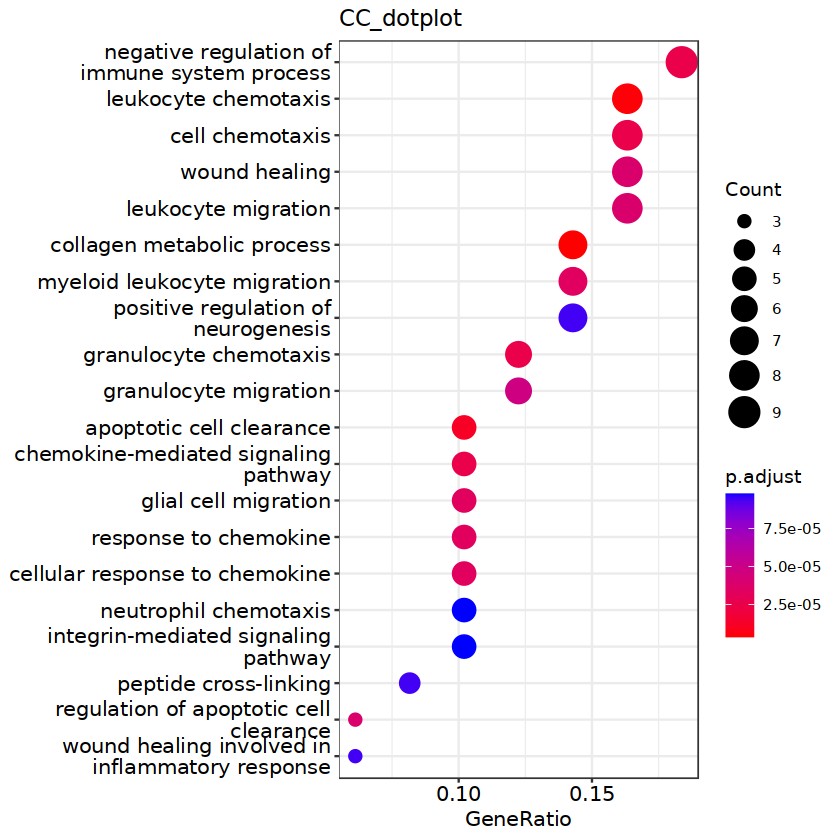

In [24]:
dotplot(CC,  #GO富集分析结果
        x = "GeneRatio",  #横坐标,默认GeneRation,也可以为Count
        color = "p.adjust",  #右纵坐标,默认p.adjust,也可以为pvalue和qvalue
        showCategory = 20,  #展示前20个点，默认为10个
        size = NULL,  #点的大小
        title = "CC_dotplot"  #设置图片的标题
        )